In [1]:
# импортируем библиотеки и реализуем обратное преобразование Бокса-Кокса
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [5]:
# считываем данные и смотрим на их начало и размер
data = pd.read_csv('WAG_C_M.csv', sep=';', header=0, index_col=['month'], parse_dates=['month'], dayfirst=True)
print(data.shape)
data.head()

(284, 1)


,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


# 1. Визуальный анализ ряда

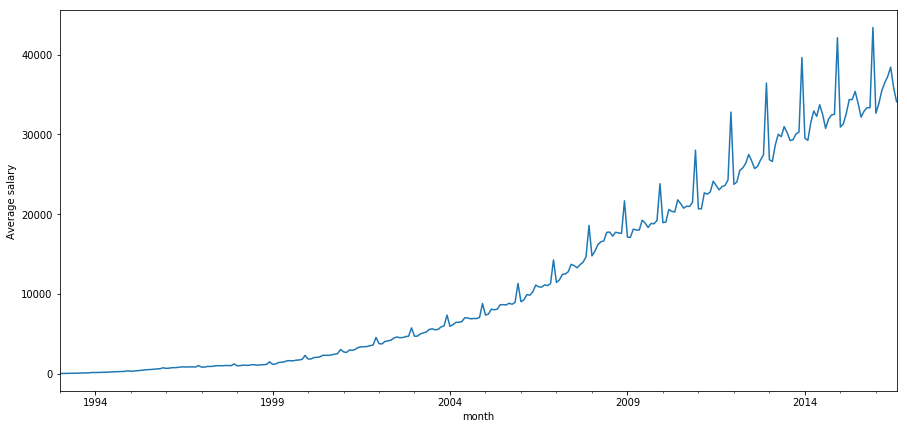

In [6]:
# строим график ряда
plt.figure(figsize=(15, 7))
data.WAG_C_M.plot()
plt.ylabel('Average salary')
pylab.show()

На графике видна отчетливая годовая сезонность, а так же сильный возрастающий тренд. У ряда очень сильно меняется дисперсия. С помощью критерия Дики-Фуллера убедимся, что ряд нельзя считать стационарным, а так же посмотрим на декомпозицию ряда.

Критерий Дики-Фуллера: p=0.9918495954854735


<Figure size 1080x720 with 0 Axes>

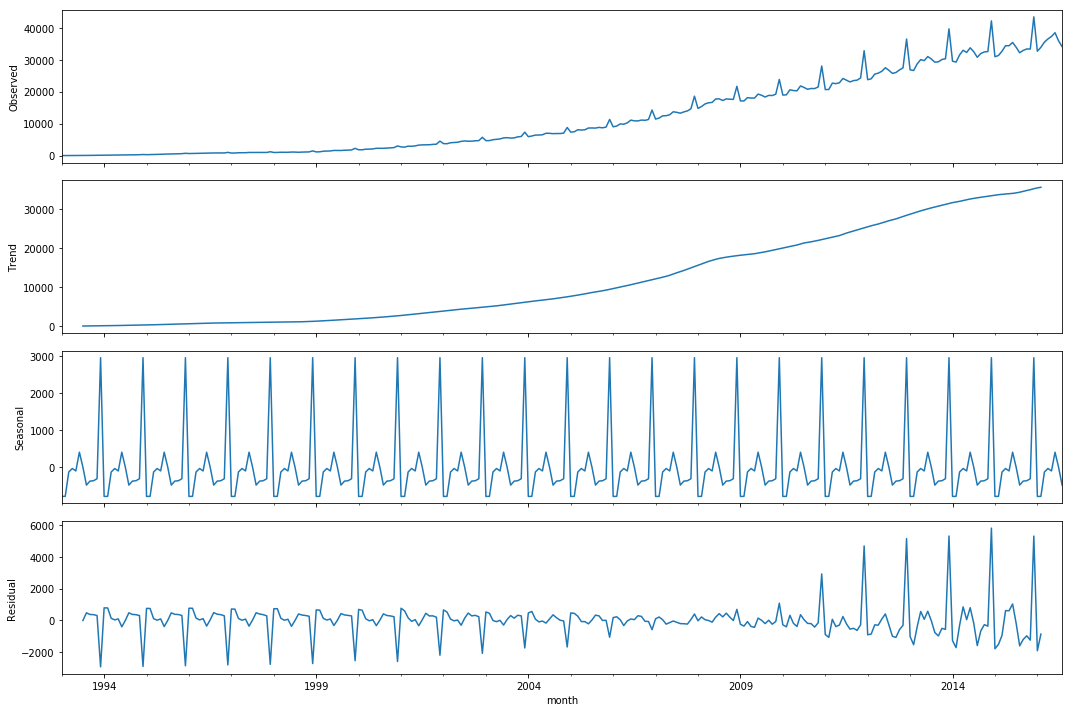

In [8]:
# STL-декомпозиция и критерий Дики-Фуллера
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p={}".format(sm.tsa.stattools.adfuller(data.WAG_C_M)[1]))

# 2. Стабилизация дисперсии

lambda = 0.2632017541844584
Критерий Дики-Фуллера: p=0.6968987634832744


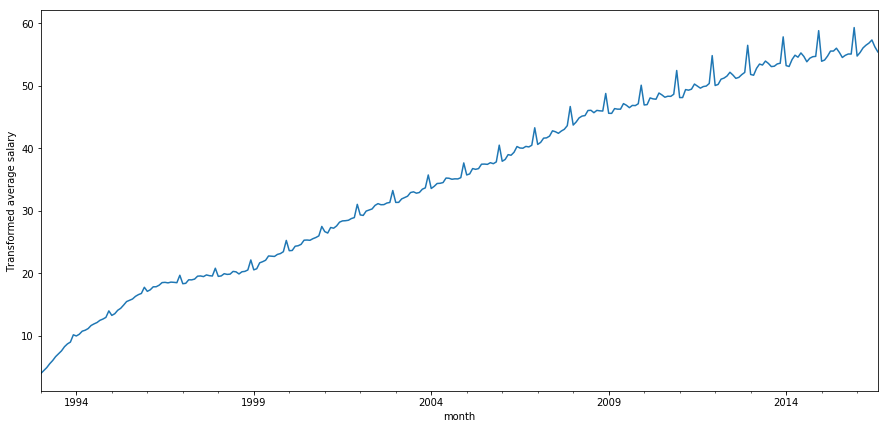

In [9]:
# делаем преобразование Бокса-Кокса, чтобы стабилизировать дисперсию, и снова смотрим на критерий Дики-Фуллера
data['WAG_C_M_new'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize=(15, 7))
data.WAG_C_M_new.plot()
plt.ylabel('Transformed average salary')
print("lambda = {}".format(lmbda))
print("Критерий Дики-Фуллера: p={}".format(sm.tsa.stattools.adfuller(data.WAG_C_M_new)[1]))

Ряд все еще нестационарен, что видно глазом и подтверждается критерием. Сезонно продифференцируем его $(S = 12)$, и снова вычислим критерий Дики-Фуллера.

# 3. Выбор порядка дифференцирования 

Критерий Дики-Фуллера: p=0.014697133494791808


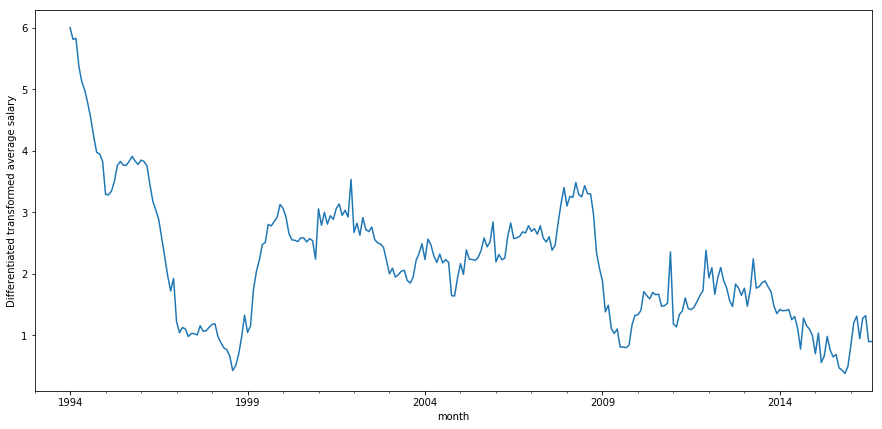

In [11]:
# сезонное дифференцирование, вычисление критерия
S = 12
data['WAG_C_M_diff'] = data.WAG_C_M_new - data.WAG_C_M_new.shift(S)
plt.figure(figsize(15,7))
data.WAG_C_M_diff.plot()
plt.ylabel('Differentiated transformed average salary')
print("Критерий Дики-Фуллера: p={}".format(sm.tsa.stattools.adfuller(data.WAG_C_M_diff[12:])[1]))

Критерий отвергает гипотезу нестационарности полученного ряда, хотя на графике виден тренд. Продифференцируем ряд обычным образом.

Критерий Дики-Фуллера: p=5.203603715821878e-08


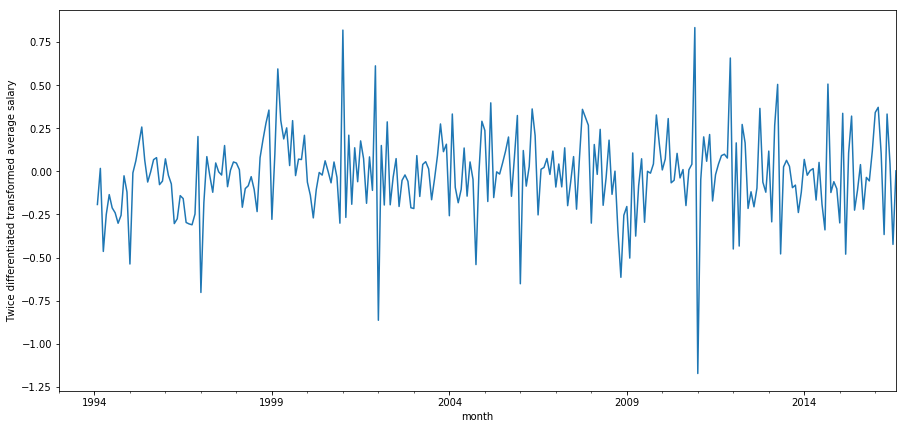

In [12]:
# обычное дифференцирование, вычисление критерия
data['WAG_C_M_diff2'] = data.WAG_C_M_diff - data.WAG_C_M_diff.shift(1)
plt.figure(figsize(15,7))
data.WAG_C_M_diff2.plot()
plt.ylabel('Twice differentiated transformed average salary')
print("Критерий Дики-Фуллера: p={}".format(sm.tsa.stattools.adfuller(data.WAG_C_M_diff2[13:])[1]))

На этот раз можно сказать, что полученный ряд стационарен: это подтверждает как график, так и критерий с большой уверенностью.

In [13]:
# фиксируем d и D
d, D = 1, 1

# 4. Выбор начальных приближений для $p, q, P, Q$ 

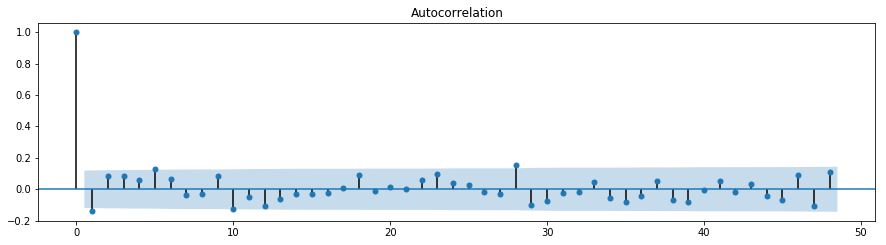

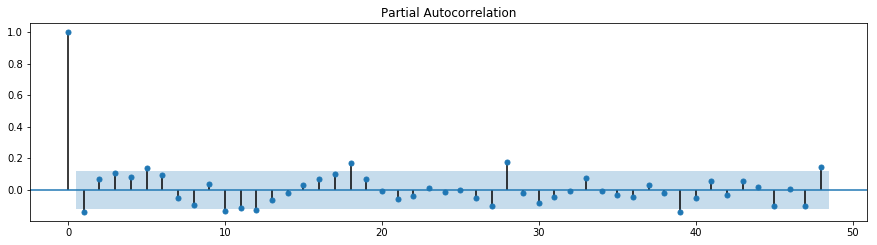

In [14]:
# смотрим на автокорреляцию и частичную автокорреляцию
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

На первом графике нет значимых сезонных лагов: $Q = 0$. Наибольший значимый адекватный несезонный лаг - $q = 10$.

На втором графике значим сезонный лаг $48$, отсюда $P = 4$. Наибольший значимый несезонный лаг - $p = 11$.

In [20]:
# создаем сетку параметров
ps = range(0, 12)
qs = range(0, 11)
Ps = range(0, 5)
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

660

# 5. Обучение и сравнение моделей-кандидатов, выбор победителя 

In [29]:
%%time
# обучаем и сравниваем модели
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for i, param in enumerate(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_new, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], S)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    print("finished fitting with {}, {} more to go".format(param, 659 - i))
    
warnings.filterwarnings('default')

finished fitting with (0, 0, 0, 0), 659 more to go
finished fitting with (0, 0, 1, 0), 658 more to go
finished fitting with (0, 0, 2, 0), 657 more to go
finished fitting with (0, 0, 3, 0), 656 more to go
finished fitting with (0, 0, 4, 0), 655 more to go
finished fitting with (0, 1, 0, 0), 654 more to go
finished fitting with (0, 1, 1, 0), 653 more to go
finished fitting with (0, 1, 2, 0), 652 more to go
finished fitting with (0, 1, 3, 0), 651 more to go
finished fitting with (0, 1, 4, 0), 650 more to go
finished fitting with (0, 2, 0, 0), 649 more to go
finished fitting with (0, 2, 1, 0), 648 more to go
finished fitting with (0, 2, 2, 0), 647 more to go
finished fitting with (0, 2, 3, 0), 646 more to go
finished fitting with (0, 2, 4, 0), 645 more to go
finished fitting with (0, 3, 0, 0), 644 more to go
finished fitting with (0, 3, 1, 0), 643 more to go
finished fitting with (0, 3, 2, 0), 642 more to go
finished fitting with (0, 3, 3, 0), 641 more to go
finished fitting with (0, 3, 4,

finished fitting with (2, 10, 1, 0), 498 more to go
finished fitting with (2, 10, 2, 0), 497 more to go
finished fitting with (2, 10, 3, 0), 496 more to go
finished fitting with (2, 10, 4, 0), 495 more to go
finished fitting with (3, 0, 0, 0), 494 more to go
finished fitting with (3, 0, 1, 0), 493 more to go
finished fitting with (3, 0, 2, 0), 492 more to go
finished fitting with (3, 0, 3, 0), 491 more to go
finished fitting with (3, 0, 4, 0), 490 more to go
finished fitting with (3, 1, 0, 0), 489 more to go
finished fitting with (3, 1, 1, 0), 488 more to go
finished fitting with (3, 1, 2, 0), 487 more to go
finished fitting with (3, 1, 3, 0), 486 more to go
finished fitting with (3, 1, 4, 0), 485 more to go
finished fitting with (3, 2, 0, 0), 484 more to go
finished fitting with (3, 2, 1, 0), 483 more to go
finished fitting with (3, 2, 2, 0), 482 more to go
finished fitting with (3, 2, 3, 0), 481 more to go
finished fitting with (3, 2, 4, 0), 480 more to go
finished fitting with (3, 3

finished fitting with (5, 9, 2, 0), 337 more to go
finished fitting with (5, 9, 3, 0), 336 more to go
finished fitting with (5, 9, 4, 0), 335 more to go
finished fitting with (5, 10, 0, 0), 334 more to go
finished fitting with (5, 10, 1, 0), 333 more to go
finished fitting with (5, 10, 2, 0), 332 more to go
finished fitting with (5, 10, 3, 0), 331 more to go
finished fitting with (5, 10, 4, 0), 330 more to go
finished fitting with (6, 0, 0, 0), 329 more to go
finished fitting with (6, 0, 1, 0), 328 more to go
finished fitting with (6, 0, 2, 0), 327 more to go
finished fitting with (6, 0, 3, 0), 326 more to go
finished fitting with (6, 0, 4, 0), 325 more to go
finished fitting with (6, 1, 0, 0), 324 more to go
finished fitting with (6, 1, 1, 0), 323 more to go
finished fitting with (6, 1, 2, 0), 322 more to go
finished fitting with (6, 1, 3, 0), 321 more to go
finished fitting with (6, 1, 4, 0), 320 more to go
finished fitting with (6, 2, 0, 0), 319 more to go
finished fitting with (6, 

finished fitting with (8, 8, 3, 0), 176 more to go
finished fitting with (8, 8, 4, 0), 175 more to go
finished fitting with (8, 9, 0, 0), 174 more to go
finished fitting with (8, 9, 1, 0), 173 more to go
finished fitting with (8, 9, 2, 0), 172 more to go
finished fitting with (8, 9, 3, 0), 171 more to go
finished fitting with (8, 9, 4, 0), 170 more to go
finished fitting with (8, 10, 0, 0), 169 more to go
finished fitting with (8, 10, 1, 0), 168 more to go
finished fitting with (8, 10, 2, 0), 167 more to go
finished fitting with (8, 10, 3, 0), 166 more to go
finished fitting with (8, 10, 4, 0), 165 more to go
finished fitting with (9, 0, 0, 0), 164 more to go
finished fitting with (9, 0, 1, 0), 163 more to go
finished fitting with (9, 0, 2, 0), 162 more to go
finished fitting with (9, 0, 3, 0), 161 more to go
finished fitting with (9, 0, 4, 0), 160 more to go
finished fitting with (9, 1, 0, 0), 159 more to go
finished fitting with (9, 1, 1, 0), 158 more to go
finished fitting with (9, 

finished fitting with (11, 7, 4, 0), 15 more to go
finished fitting with (11, 8, 0, 0), 14 more to go
finished fitting with (11, 8, 1, 0), 13 more to go
finished fitting with (11, 8, 2, 0), 12 more to go
finished fitting with (11, 8, 3, 0), 11 more to go
finished fitting with (11, 8, 4, 0), 10 more to go
finished fitting with (11, 9, 0, 0), 9 more to go
finished fitting with (11, 9, 1, 0), 8 more to go
finished fitting with (11, 9, 2, 0), 7 more to go
finished fitting with (11, 9, 3, 0), 6 more to go
finished fitting with (11, 9, 4, 0), 5 more to go
finished fitting with (11, 10, 0, 0), 4 more to go
finished fitting with (11, 10, 1, 0), 3 more to go
finished fitting with (11, 10, 2, 0), 2 more to go
finished fitting with (11, 10, 3, 0), 1 more to go
finished fitting with (11, 10, 4, 0), 0 more to go
CPU times: user 5h 17min 55s, sys: 1min 10s, total: 5h 19min 5s
Wall time: 1h 23min 24s


In [30]:
# смотрим на лучшие результаты
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
301  (5, 5, 1, 0) -25.145526
351  (6, 4, 1, 0) -24.885561
251  (4, 6, 1, 0) -24.884565
246  (4, 5, 1, 0) -23.665911
302  (5, 5, 2, 0) -23.579412


In [31]:
# смотрим на лучшую модель
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_new   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.573
Date:                            Sun, 08 Sep 2019   AIC                            -25.146
Time:                                    17:03:39   BIC                             18.080
Sample:                                01-01-1993   HQIC                            -7.790
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2203      0.783     -0.281      0.778      -1.755       1.314
ar.L2          0.2442      0.554   

# 6. Анализ остатков построенной модели 

Критерий Стьюдента: p=0.166819
Критерий Дики-Фуллера: p=0.000000


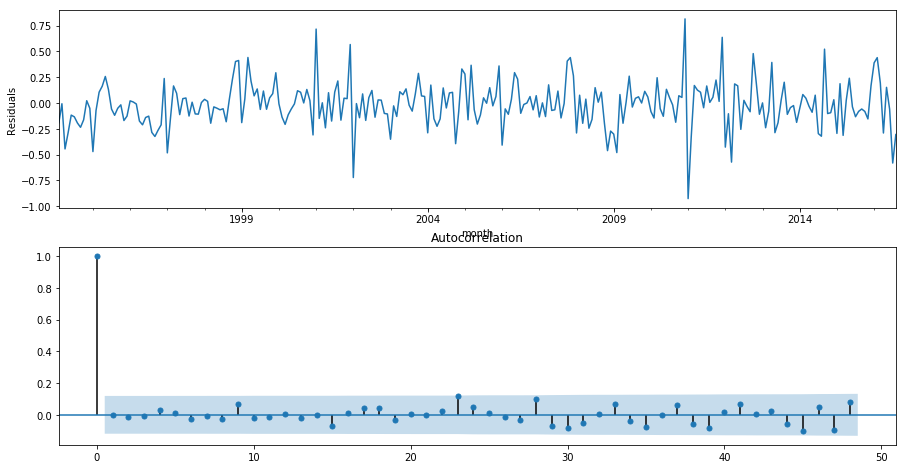

In [32]:
# смотрим на остатки
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Модель имеет несмещенные и неавтокоррелированные остатки, поэтому корректировка не требуется.

# 7. Прогнозирование с помощью финальной модели

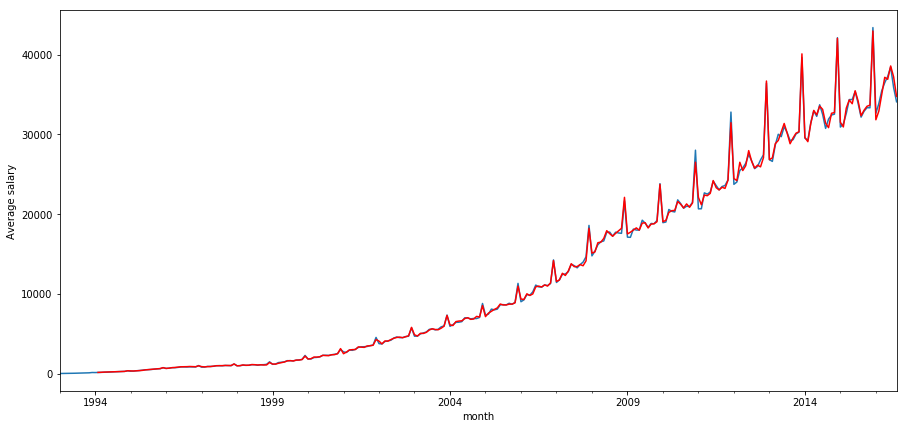

In [37]:
# строим предсказанный моделью ряд поверх известного
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Average salary')
pylab.show()

Полученная модель очень хорошо описывает известные данные. Теперь сделаем прогноз на два года.

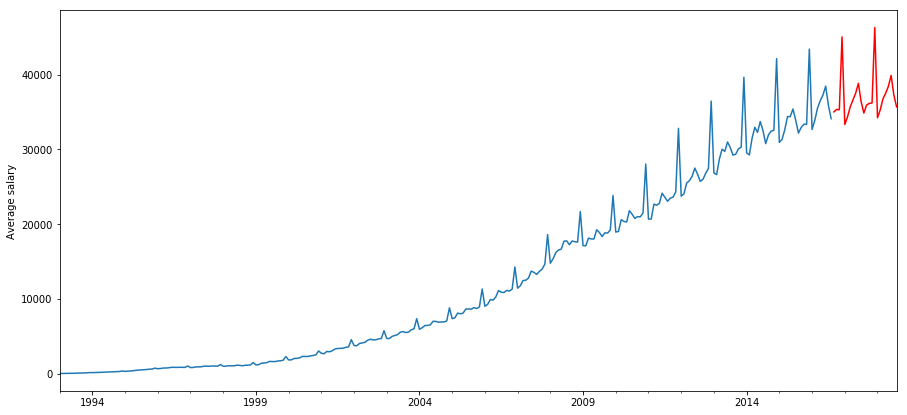

In [36]:
# делаем предсказание на два года вперед
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Average salary')
pylab.show()